### Imports

In [274]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from scipy.special import linestyle
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define non noisy ground truth system

In [288]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.

### A function to generate training data for dynamics model

In [326]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param sys: (psl.system) the system being simulated
    :param nsim: (int) Total number of simulation points
    :param nsteps: (int) Number of timesteps per batch
    :param ts: (float) Simulation step size
    :param bs: (int) Batch size
    """

    nx = sys.nx  # Number of state variables (e.g., 2 for x1, x2)
    nu = sys.nu  # Number of control inputs
    nbatch = nsim // nsteps
    length = nbatch * nsteps

    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for _ in range(3)]


    trainX_full = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)

    trainX_1 = trainX_full[:, :, 0:1]
    trainX_2 = trainX_full[:, :, 1:2]

    trainX_full = torch.tensor(trainX_full, dtype=torch.float32).to(device)
    trainX_1 = torch.tensor(trainX_1, dtype=torch.float32).to(device)
    trainX_2 = torch.tensor(trainX_2, dtype=torch.float32).to(device)  # Treat as fixed input
    trainU = torch.tensor(trainU, dtype=torch.float32).to(device)

    train_data = DictDataset({'X': trainX_full, 'xn': trainX_full[:, 0:1, :], 'x1': trainX_1, 'x1_n': trainX_1[:, 0:1, :] , 'x2': trainX_2, 'x2_n': trainX_2[:, 0:1, :],  'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs, collate_fn=train_data.collate_fn, shuffle=True)

    # Separate x1 and x2 in dev data
    devX_full = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)

    devX_1 = devX_full[:, :, 0:1]
    devX_2 = devX_full[:, :, 1:2]

    devX_full = torch.tensor(devX_full, dtype=torch.float32).to(device)
    devX_1 = torch.tensor(devX_1, dtype=torch.float32).to(device)
    devX_2 = torch.tensor(devX_2, dtype=torch.float32).to(device)
    devU = torch.tensor(devU, dtype=torch.float32).to(device)

    dev_data = DictDataset({'X': devX_full, 'xn': devX_full[:, 0:1, :],  'x1': devX_1, 'x1_n': devX_1[:, 0:1, :], 'x2': devX_2, 'x2_n': devX_2[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True)

    # Test set: Keep only x1 and x2
    testX_full = test_sim['X'][:length].reshape(1, nbatch * nsteps, nx)
    testU = test_sim['U'][:length].reshape(1, nbatch * nsteps, nu)

    testX_1 = testX_full[:, :, 0:1]
    testX_2 = testX_full[:, :, 1:2]

    testX_full = torch.tensor(testX_full, dtype=torch.float32).to(device)
    testX_1 = torch.tensor(testX_1, dtype=torch.float32).to(device)
    testX_2 = torch.tensor(testX_2, dtype=torch.float32).to(device)
    testU = torch.tensor(testU, dtype=torch.float32).to(device)

    test_data = {'X': testX_full, 'xn': testX_full[:, 0:1, :],  'x1': testX_1, 'x1_n': testX_1[:, 0:1, :], 'x2_n': testX_2[:, 0:1, :], 'x2': testX_2, 'u': testU}

    return train_loader, dev_loader, test_data


In [327]:
nsim = 3000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 16      # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)


# define neural network of the NODE
fx = blocks.MLP(nx+nu, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[80, 80, 80])

# integrate NODE with RK4
fxRK4 = integrators.RK4(fx, h=ts)
# create symbolic system model in Neuromancer
model = Node(fxRK4, ['xn', 'u'], ['xn'], name='NODE')
dynamics_model = System([model], name='system')



In [330]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 5. *(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# aggregate list of objective terms and constraints
objectives = [reference_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [332]:
optimizer = torch.optim.Adam(fx.parameters(),
                             lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    None,
    None,
    test_data,
    optimizer,
    patience=300,
    warmup=100,
    epochs=900,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 13522


In [333]:
nsteps=2
for i in range(3):
    print(f'************   training with {nsteps} steps   ************   ')

    # Regenerate data for the new `nsteps`
    train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)
    dynamics_model.nsteps = nsteps
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem  # Keep the problem consistent

    # Train control policy
    best_model = trainer.train()


    trainer.model.load_state_dict(best_model)

    # Update step size
    nsteps *= 2

    # reset early stopping
    trainer.badcount = 0

************   training with 2 steps   ************   
epoch: 0	train_loss: 0.00000	dev_loss: 0.00001	eltime:  5.75992
epoch: 1	train_loss: 0.00000	dev_loss: 0.00000	eltime:  6.07489
epoch: 2	train_loss: 0.00000	dev_loss: 0.00000	eltime:  6.38431
epoch: 3	train_loss: 0.00000	dev_loss: 0.00000	eltime:  6.65284
epoch: 4	train_loss: 0.00000	dev_loss: 0.00000	eltime:  6.87323
epoch: 5	train_loss: 0.00000	dev_loss: 0.00000	eltime:  7.10160
epoch: 6	train_loss: 0.00000	dev_loss: 0.00000	eltime:  7.36874
epoch: 7	train_loss: 0.00000	dev_loss: 0.00000	eltime:  7.58547
epoch: 8	train_loss: 0.00000	dev_loss: 0.00000	eltime:  7.81223
epoch: 9	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.04629
epoch: 10	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.28426
epoch: 11	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.51673
epoch: 12	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.73708
epoch: 13	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.95352
epoch: 14	train_loss: 0.00000	dev_loss: 0.000

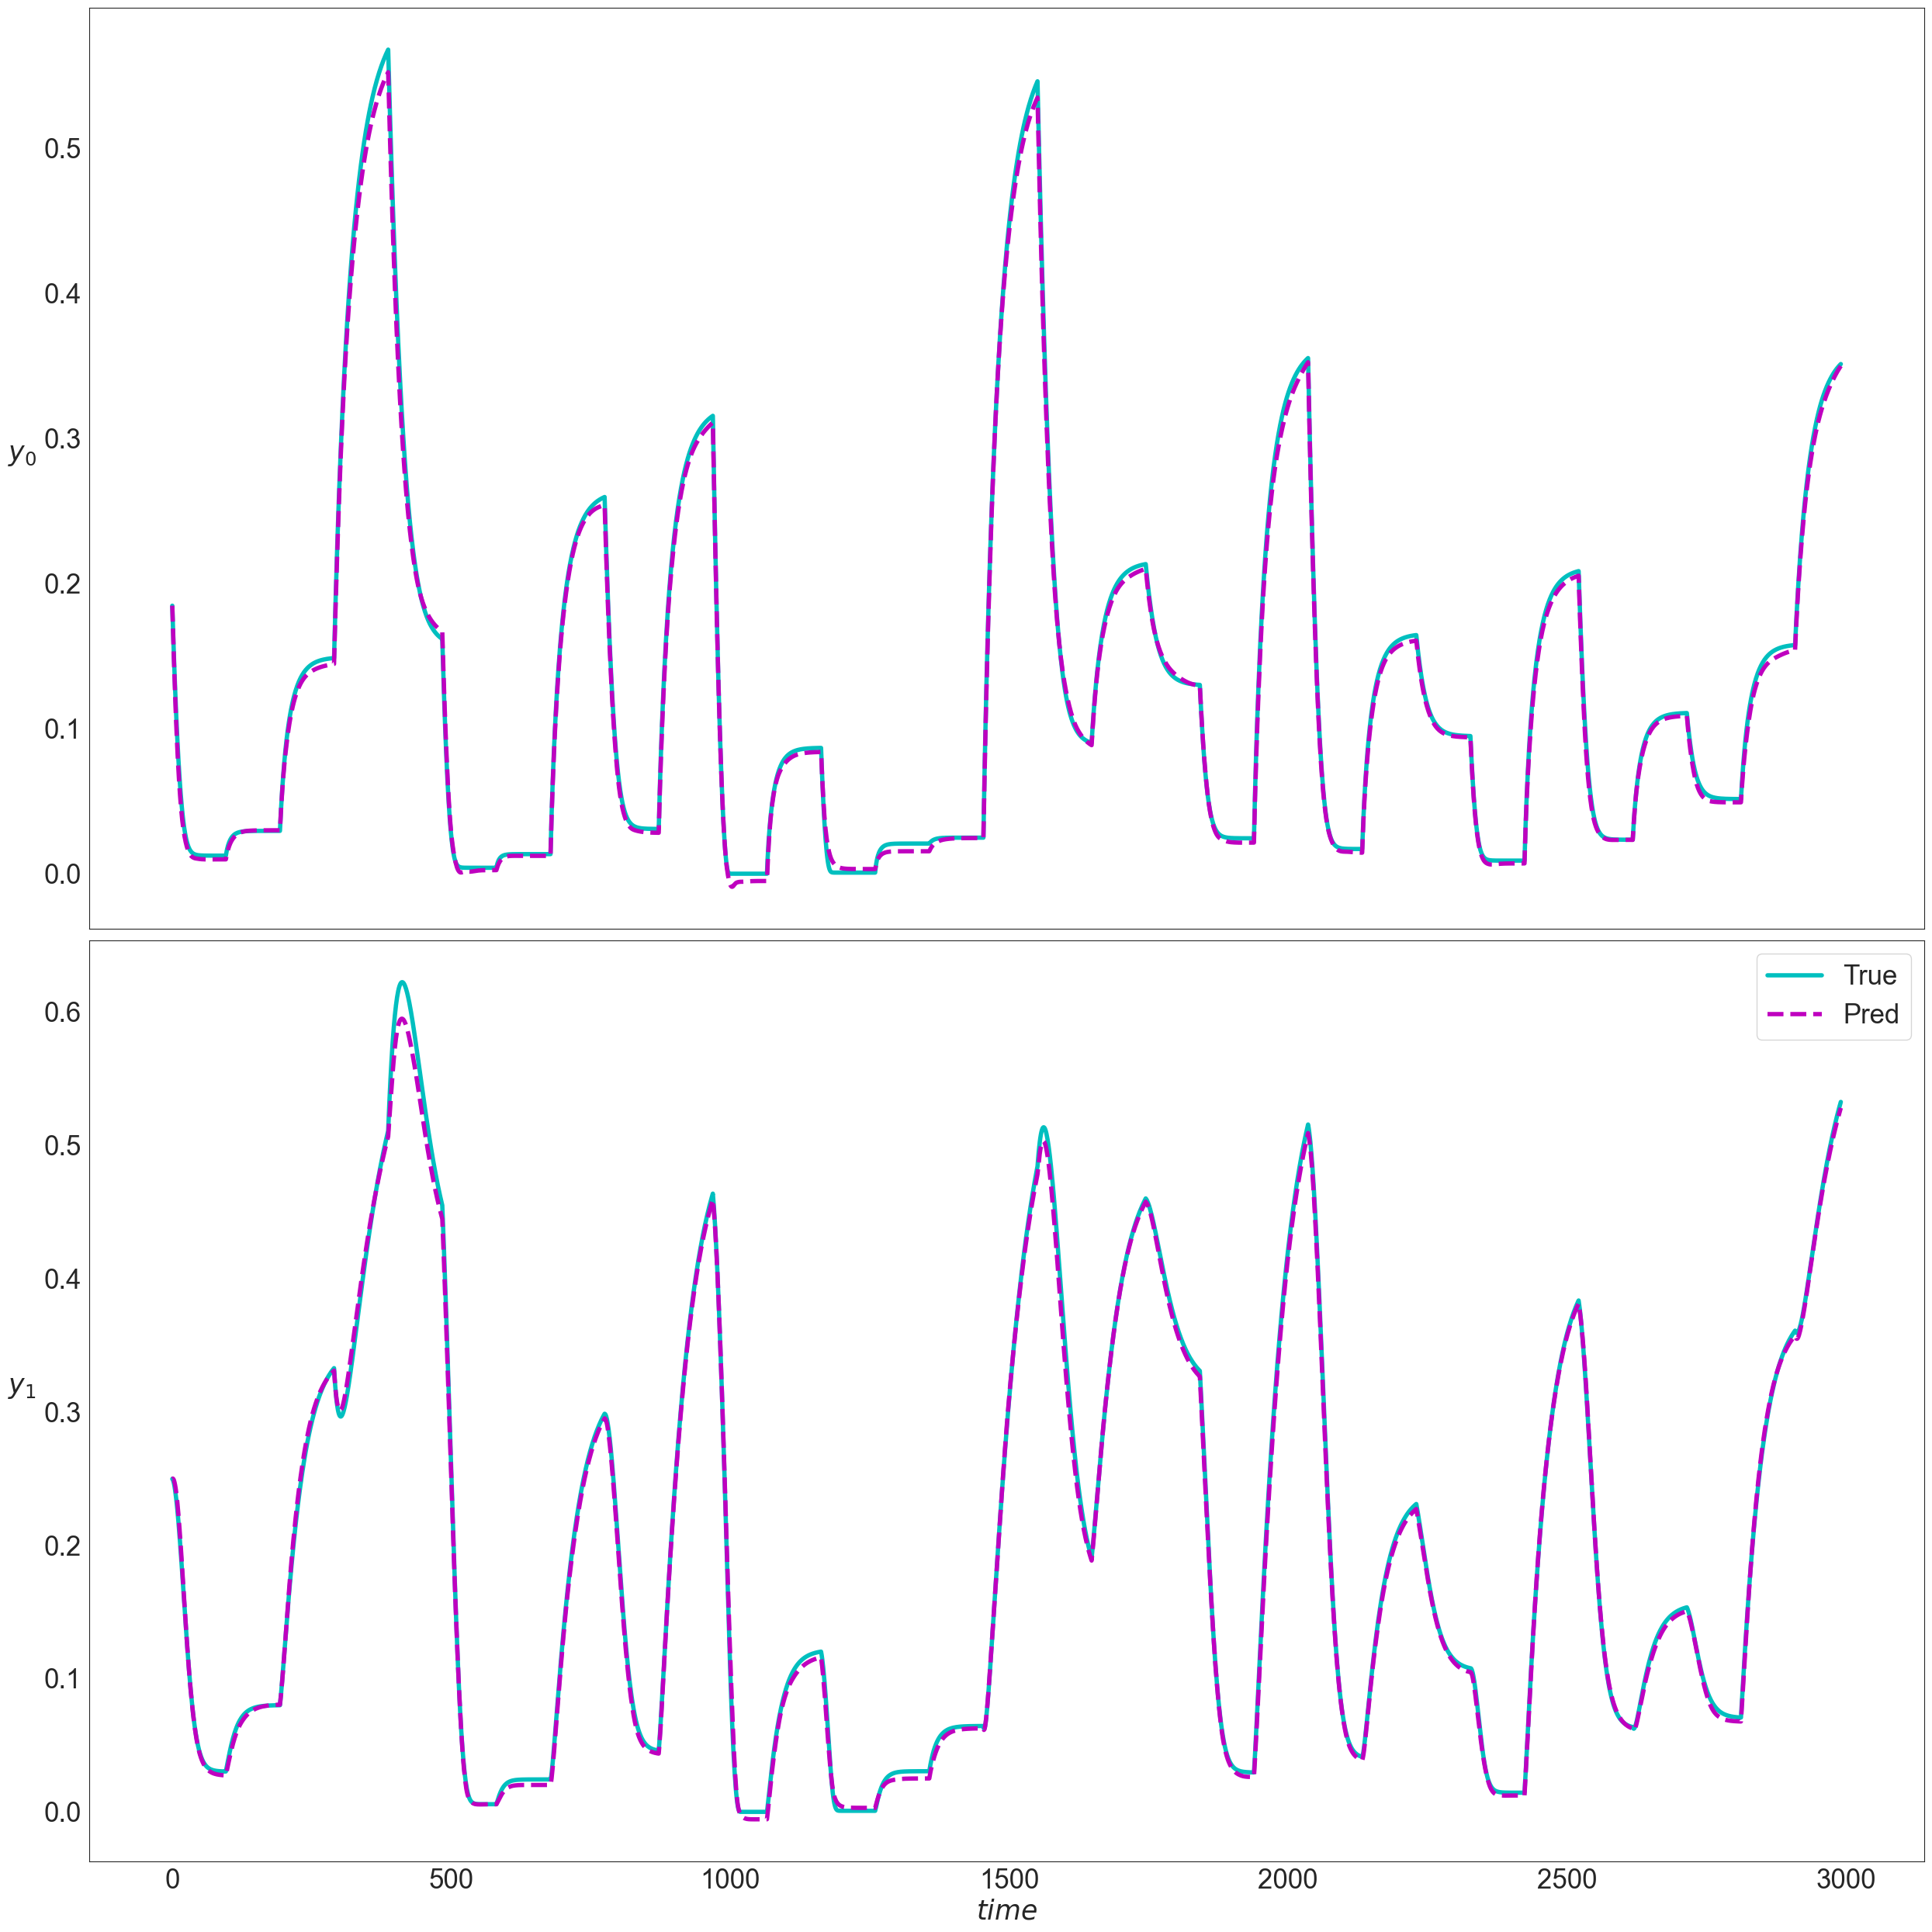

In [335]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)

dynamics_model.nsteps = test_data['X'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

### A function to generate training data for policy

In [343]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    train_xn = torch.rand(n_samples, 1, nx)
    train_x1_n = train_xn[:,:,0:1]
    train_x2_n = train_xn[:,:,1:2]
    # Training dataset
    train_data = DictDataset({'xn': train_xn.to(device),   # sampled initial conditions of states
                              'x1_n': train_x1_n.to(device),
                              'x2_n': train_x2_n.to(device),
                              'r': batched_ref.to(device)}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    dev_xn = torch.rand(n_samples, 1, nx)
    dev_x1_n = dev_xn[:,:,0:1]
    dev_x2_n = dev_xn[:,:,1:2]
    # Development dataset
    dev_data = DictDataset({'xn': dev_xn.to(device),   # sampled initial conditions of states
                              'x1_n': dev_x1_n.to(device),
                              'x2_n': dev_x2_n.to(device),
                              'r': batched_ref.to(device)}, name='dev')

    # torch dataloaders
    batch_size = 32
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader
nsteps = 60  # prediction horizon
n_samples = 2000    # number of sampled scenarios
train_loader, dev_loader = get_policy_data(nsteps, n_samples)

### Training the Policy with the pretrained dynamics model NODE

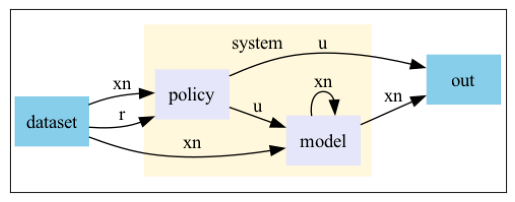

In [344]:
from neuromancer.modules.activations import activations

# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = torch.nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = torch.nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
gt_integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator

# # white-box ODE model with no-plant model mismatch
# vdp_ode = ode.VanDerPolControl()
# vdp_ode.mu = torch.nn.Parameter(torch.tensor(gt_model.mu), requires_grad=False)
# # integrate continuous time ODE
# gt_integrator = integrators.RK4(vdp_ode, h=torch.tensor(ts))

# symbolic system model
sys_node = Node(gt_integrator, ['xn', 'u'], ['xn'], name='system')

# symbolic system model
model = Node(fxRK4, ['xn', 'u'], ['xn'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
cl_system.show()

In [345]:
# variables
x = variable('xn')
ref = variable("r")
# objectives
regulation_loss = 100. * ((x == ref) ^ 2)  # target posistion
# state bound constraints
state_lower_bound_penalty = 10.0*(x > xmin)
state_upper_bound_penalty = 10.0*(x < xmax)
# state terminal penalties
terminal_lower_bound_penalty = 20.0*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 20.0*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()


In [346]:

optimizer = torch.optim.AdamW(policy.parameters(), lr=0.003)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=500,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=100,
    patience=100,
    logger=logger,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)


None
Number of parameters: 14804
epoch: 0	train_loss: 5.16796	dev_loss: 6.29945	eltime:  4.51439
epoch: 1	train_loss: 4.14424	dev_loss: 5.19474	eltime:  8.95306
epoch: 2	train_loss: 3.82182	dev_loss: 4.90395	eltime:  13.30007
epoch: 3	train_loss: 3.69396	dev_loss: 4.74150	eltime:  18.64789
epoch: 4	train_loss: 3.61855	dev_loss: 4.63457	eltime:  23.26294
epoch: 5	train_loss: 3.56709	dev_loss: 4.57307	eltime:  27.75427
epoch: 6	train_loss: 3.52911	dev_loss: 4.53159	eltime:  32.25926
epoch: 7	train_loss: 3.50092	dev_loss: 4.50413	eltime:  37.09394
epoch: 8	train_loss: 3.47876	dev_loss: 4.48466	eltime:  41.59107
epoch: 9	train_loss: 3.47466	dev_loss: 4.47152	eltime:  46.07713
epoch: 10	train_loss: 3.46850	dev_loss: 4.46169	eltime:  50.56280
epoch: 11	train_loss: 3.45866	dev_loss: 4.45320	eltime:  54.93144
epoch: 12	train_loss: 3.45353	dev_loss: 4.44708	eltime:  59.33370
epoch: 13	train_loss: 3.46590	dev_loss: 4.44132	eltime:  63.73549
epoch: 14	train_loss: 3.46086	dev_loss: 4.43667	eltime:

<All keys matched successfully>

In [379]:
# symbolic system model
sys_node = Node(gt_integrator, ['xn', 'u'], ['xn'], name='system')
NODE = Node(fxRK4, ['xn', 'u'], ['xn'], name='NODE')
gt_NN_policy_wb = System([policy,sys_node])

### Rollout on non noisy ground truth system

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

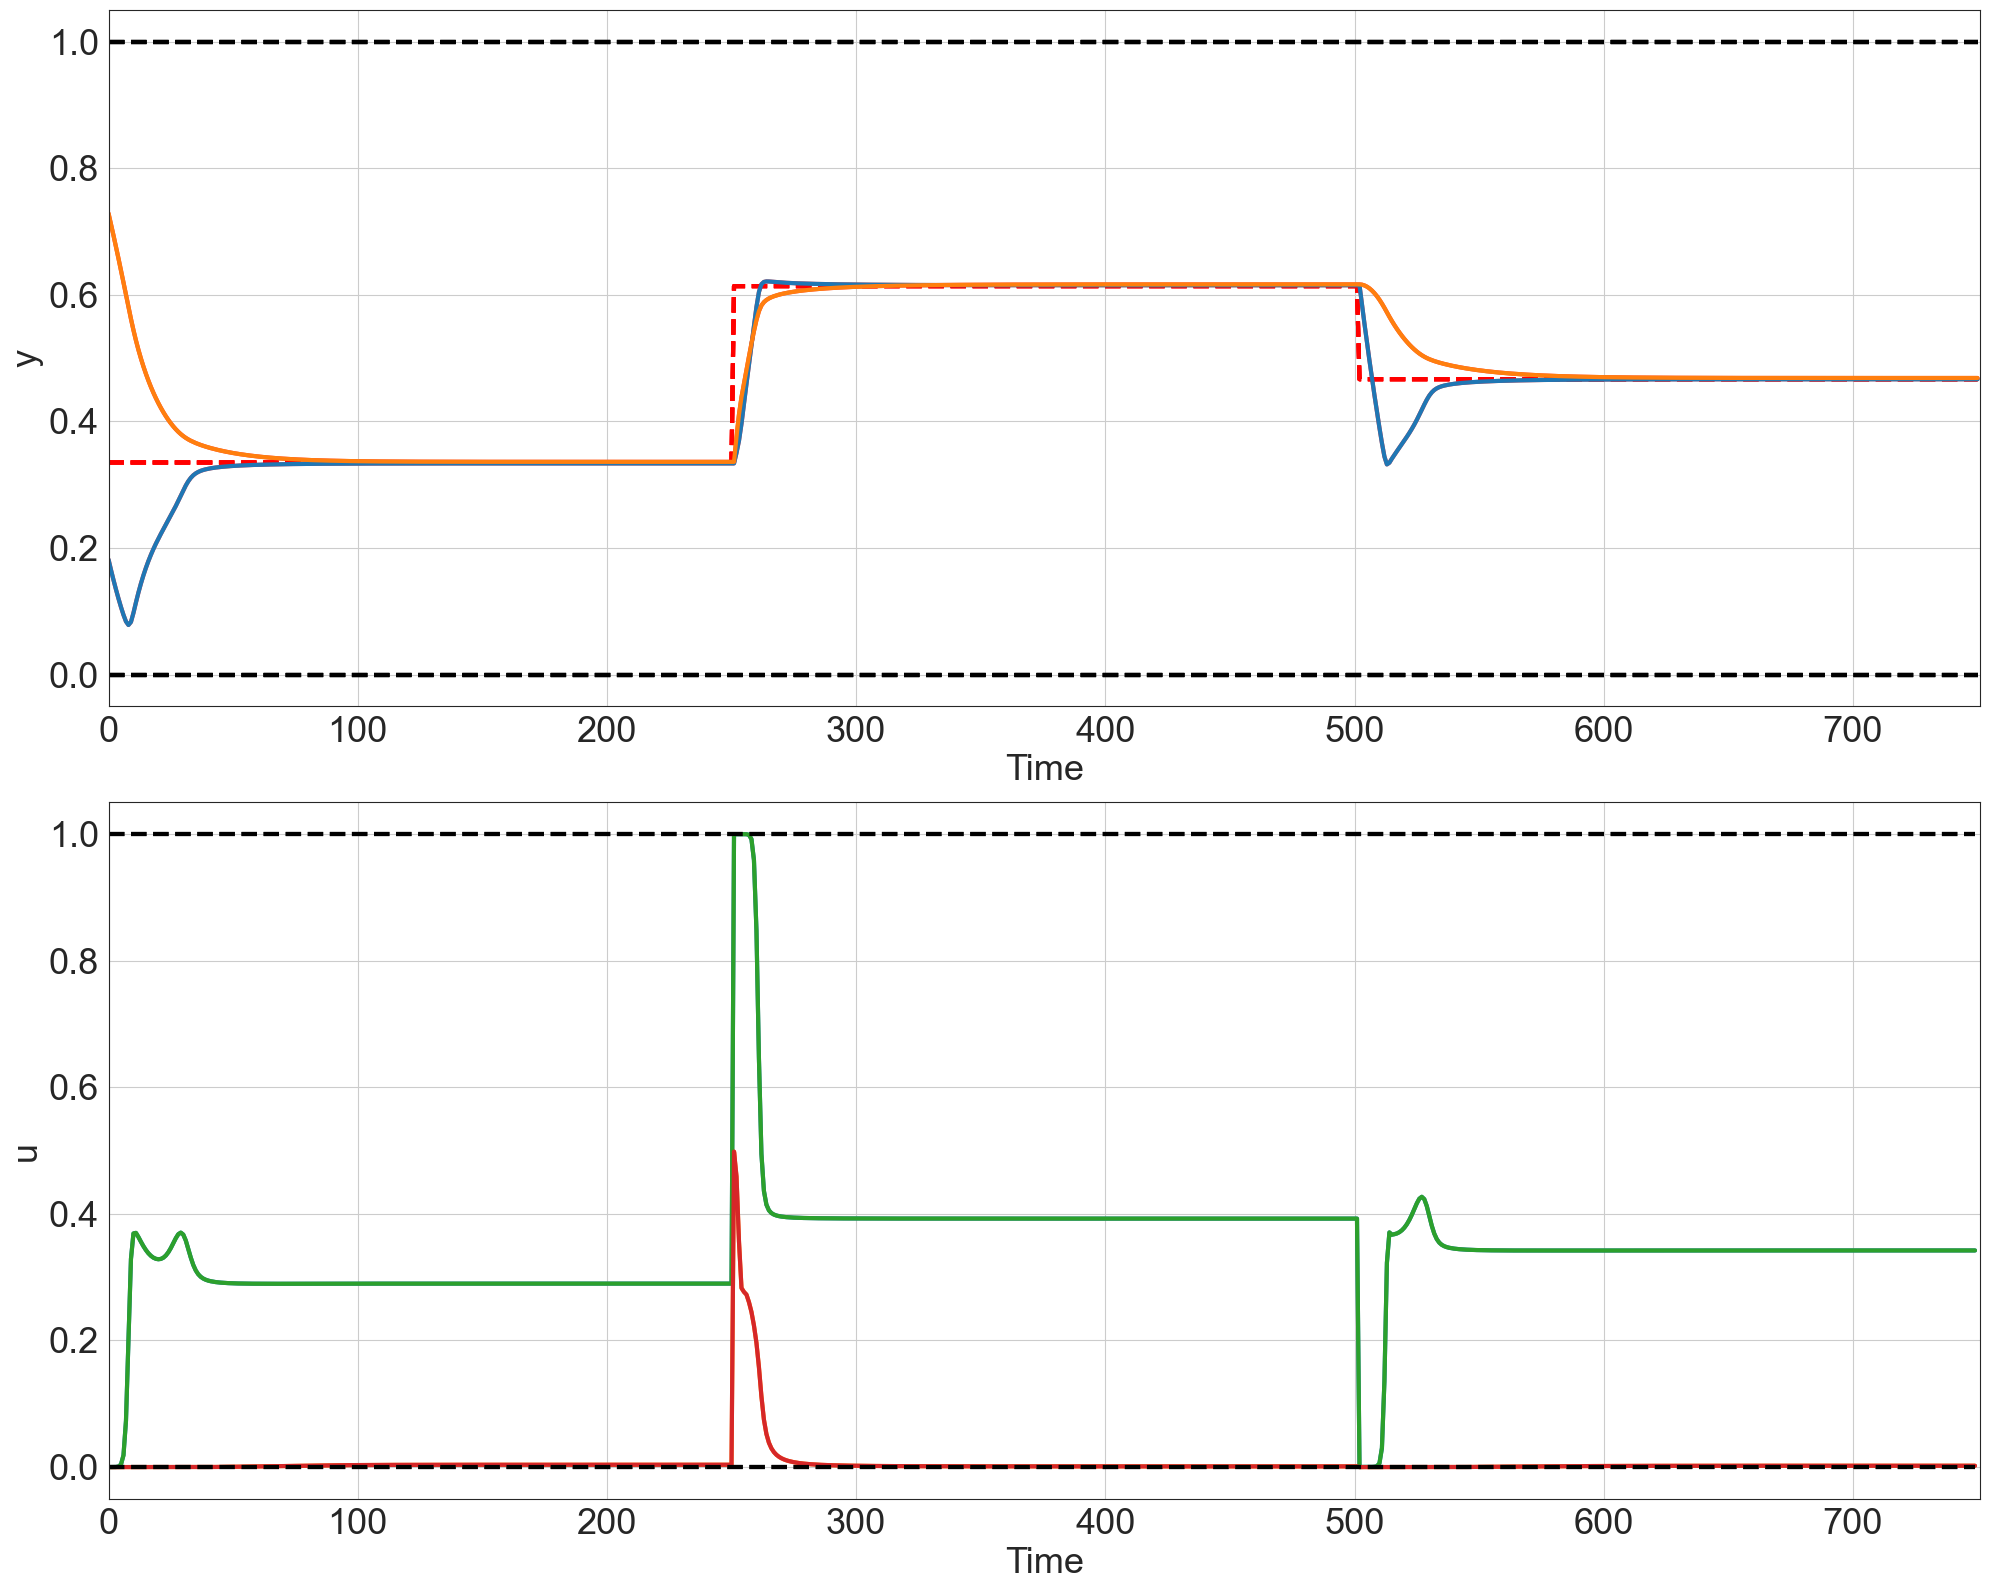

In [380]:
import numpy as np
import seaborn as sns
from neuromancer.plot import pltCL, pltPhase

sns.set_style('white')
nsteps = 750
step_length = 250
seed = 90
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=0., max=0.9, randsteps=nsteps//step_length, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

gt_NN_policy_wb.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_NN_policy_wb(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Changing the parameters of the ODE to create a noisy system

In [690]:
# # white-box ODE model with model mismatch
c1 = 0.14
c2 = 0.02
two_tank.c1 = torch.nn.Parameter(torch.tensor(c1), requires_grad=False)
two_tank.c2 = torch.nn.Parameter(torch.tensor(c2), requires_grad=False)

gt_model.c1 = np.array(c1, dtype="float32")
gt_model.c2 = np.array(c2, dtype="float32")


### Rollout on the noisy system with the trained policy

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

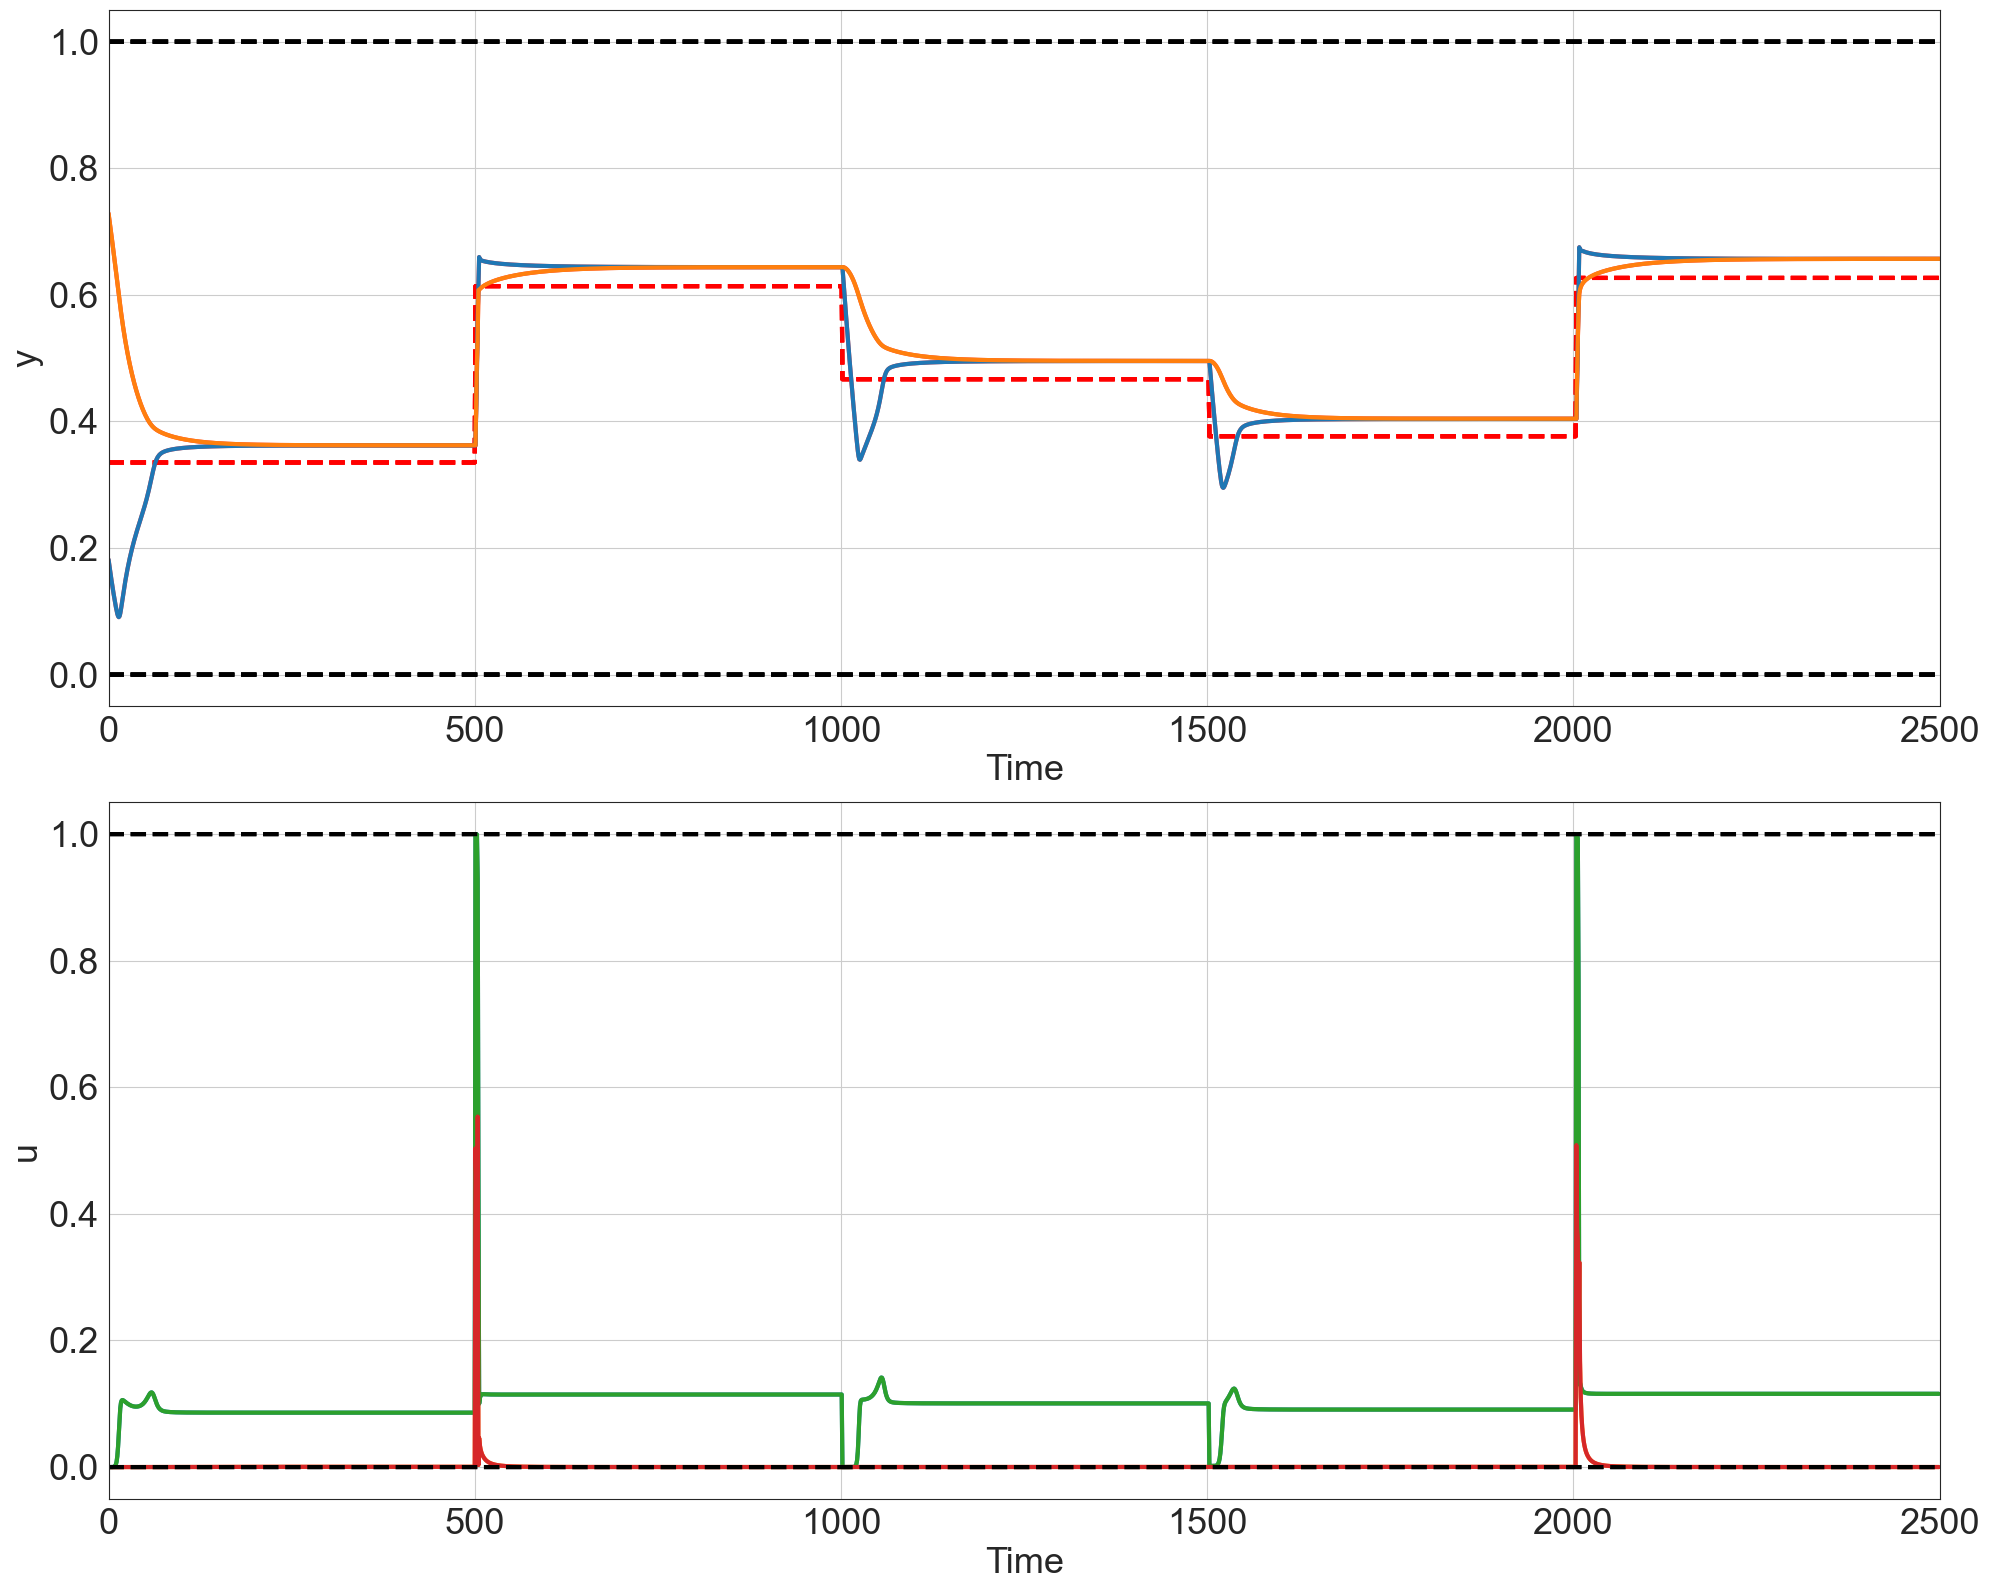

In [703]:
import numpy as np
import seaborn as sns
from neuromancer.plot import pltCL, pltPhase

sns.set_style('white')
nsteps = 2500
step_length = 500
seed = 90
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=0., max=0.9, randsteps=nsteps//step_length, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

gt_NN_policy_wb.nsteps = nsteps
# perform closed-loop simulation
trajectories_before_adaptation = gt_NN_policy_wb(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories_before_adaptation['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories_before_adaptation['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories_before_adaptation['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### A function to create training dataset for dynamics model by taking the online trajectory


In [704]:
def get_online_data(trajectory, nsteps, max_bs):
    """
    Create training data for online learning with dynamic sequence length and gradually increasing batch size.

    :param trajectory: dict containing 'X' and 'U' arrays from system rollout
    :param nsteps: Desired number of timesteps per sequence (e.g., 50)
    :param max_bs: Max batch size
    """
    X = trajectory['X']  # shape: (T, nx)
    U = trajectory['U']  # shape: (T, nu)

    nx = X.shape[1]
    nu = U.shape[1]
    nsim = U.shape[0]

    if nsim < nsteps:
        # Not enough data to form a full sequence — use what we have
        current_steps = nsim
        nbatch = 1
        bs = 1
    else:
        current_steps = nsteps
        nbatch = nsim // current_steps
        bs = min(nbatch, max_bs)

    length = nbatch * current_steps
    X = X[:length].reshape(nbatch, current_steps, nx)
    U = U[:length].reshape(nbatch, current_steps, nu)

    X_1 = X[:, :, 0:1]
    X_2 = X[:, :, 1:2]

    # Convert to tensors
    X = torch.tensor(X, dtype=torch.float32).to(device)
    X_1 = torch.tensor(X_1, dtype=torch.float32).to(device)
    X_2 = torch.tensor(X_2, dtype=torch.float32).to(device)
    U = torch.tensor(U, dtype=torch.float32).to(device)

    _, dev_loader, _ = get_data(gt_model, nsim, nsteps, ts, bs)
    train_data = DictDataset({
        'X': X,
        'xn': X[:, 0:1, :],
        'x1': X_1,
        'x1_n': X_1[:, 0:1, :],
        'x2': X_2,
        'x2_n': X_2[:, 0:1, :],
        'u': U
    }, name='train')

    train_loader = DataLoader(train_data, batch_size=bs, collate_fn=train_data.collate_fn, shuffle=True)

    return train_loader, dev_loader


### Code to update the dynamics model online

In [705]:
def retrain_dynamics(dynamics_model, trajectory):
    # %% Constraints + losses:
    x = variable("X")
    xhat = variable('xn')[:, :-1, :]

    # trajectory tracking loss
    reference_loss = 20.*(xhat == x)^2
    reference_loss.name = "ref_loss"

    # one step tracking loss
    onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
    onestep_loss.name = "onestep_loss"

    # aggregate list of objective terms and constraints
    objectives = [reference_loss, onestep_loss]
    constraints = []
    # create constrained optimization loss
    loss = PenaltyLoss(objectives, constraints)
    # construct constrained optimization problem
    problem = Problem([dynamics_model], loss)

    optimizer = torch.optim.AdamW(problem.parameters(),lr=0.0001)
    # trainer
    trainer = Trainer(
        problem,
        None,
        None,
        None,
        optimizer,
        device=device,
        patience=2,
        warmup=2,
        epochs=5,
        eval_metric="dev_loss",
        train_metric="train_loss",
        dev_metric="dev_loss",
        test_metric="dev_loss",
        logger=logger,
    )

    dynamics_model.nsteps = None
    nsteps = 2
    max_bs = 100
    # Curriculum Model training
    iterations = 2
    for i in range(iterations):
        train_loader, dev_loader = \
            get_online_data(trajectory, nsteps, max_bs)
        trainer.train_data, trainer.dev_data = \
            train_loader, dev_loader

        print(f'training {nsteps} objective')
        best_model = trainer.train()
        trainer.model.load_state_dict(best_model)
        nsteps *= 2  # increase prediction horizon
        # reset early stopping
        trainer.badcount = 0


### Copy the nominal dynamics and policy models

In [706]:
import copy
# Clone the system
nominal_dynamics_model = copy.deepcopy(dynamics_model)
nominal_policy_model = copy.deepcopy(policy)

# New close-loop system with noisy system node
new_cl_system = System([nominal_policy_model, sys_node], nsteps=1)


In [707]:
nsteps = 2500
step_length = 500
seed = 90
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=0., max=0.9, randsteps=nsteps//step_length, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

# Initial state
x_trajectory = data['xn'].detach()[:, 0, :].unsqueeze(1)  # Shape: (1, 1, nx)

# Buffers to collect full trajectory for online learning
X_buffer = [x_trajectory[:, -1, :].cpu()]  # list of (1, nx)
U_buffer = []
R_buffer = []



### Define horizon and number of steps for gradient update

In [709]:
# Rollout loop
horizon = 50
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(nominal_policy_model.parameters(), lr=0.0005)
steps = 5

### Looping through the system, Collecting data, retraining dynamics, updating policy

In [710]:

for i in range(1, len(data['r'][0])):
    print('------', "Time step: ", i, '-------')

    # Prepare current step data
    current_r = data['r'][:, i - 1, :].unsqueeze(1)  # shape: (1, 1, nx)
    current_data = {
        'xn': x_trajectory[:, -1:, :],     # use last state as input
        'r': current_r,
    }

    # Roll out for one step
    trajectories = new_cl_system(current_data)

    # Save control input and new state
    U_buffer.append(trajectories['u'].detach()[:, 0, :].cpu())   # shape: (1, nu)
    X_buffer.append(trajectories['xn'].detach()[:, 0, :].cpu())  # shape: (1, nx)
    R_buffer.append(trajectories['r'].detach()[:, 0, :].cpu())

    # Update x_trajectory
    x_trajectory = torch.cat([x_trajectory, trajectories['xn'].detach()[:, -1:, :]], dim=1)

        # Stack buffers to make trajectory tensors
    X_tensor = torch.stack(X_buffer, dim=1).squeeze(0)  # shape: (T+1, nx)
    U_tensor = torch.stack(U_buffer, dim=1).squeeze(0)  # shape: (T, nu)
    R_tensor = torch.stack(R_buffer, dim=1).squeeze(0)
    # Final online trajectory dictionary for training
    online_trajectory = {
        'X': X_tensor.numpy(),  # (T+1, nx)
        'U': U_tensor.numpy(),  # (T, nu)
        'R': R_tensor.numpy()
    }

    if i % 5 == 0:
        retrain_dynamics(nominal_dynamics_model, online_trajectory)

    if i % 10 == 0:
        #gradually increasing the horizon (the warmup part we discussed):
        l_horizon = min(i,horizon)
        #Getting the last l_horizon data from trajectory data and calculate the loss
        T_xn = len(x_trajectory[0])

        #rollout using the last l_horizon data as initial state, and the following references
        control_data = {'xn': x_trajectory[:, T_xn - l_horizon-1, :].unsqueeze(0), 'r': data['r'][:, T_xn - l_horizon-1 : T_xn, :]}
        control_trajectories = System([nominal_policy_model, nominal_dynamics_model.nodes[0]], nsteps=l_horizon)(control_data)

        loss = 5. * criterion(control_trajectories['xn'][:,-l_horizon:, :], data['r'][:, T_xn - l_horizon : T_xn, :])

        #backprop through policy network
        optimizer.zero_grad()
        loss.backward()

        #taking gradient update steps
        for _ in range(steps):
            optimizer.step()
        print('-------', f"Loss in {i}th steps: ",loss.item(), '-------')



------ Time step:  1 -------
------ Time step:  2 -------
------ Time step:  3 -------
------ Time step:  4 -------
------ Time step:  5 -------
Number of parameters: 13522
training 2 objective
epoch: 0	train_loss: 0.00124	dev_loss: 0.00075	eltime:  65907.30612
epoch: 1	train_loss: 0.00118	dev_loss: 0.00072	eltime:  65907.31050
epoch: 2	train_loss: 0.00113	dev_loss: 0.00069	eltime:  65907.31416
epoch: 3	train_loss: 0.00107	dev_loss: 0.00066	eltime:  65907.31776
epoch: 4	train_loss: 0.00102	dev_loss: 0.00063	eltime:  65907.32209
training 4 objective
epoch: 5	train_loss: 0.00446	dev_loss: 0.01456	eltime:  65907.35940
epoch: 6	train_loss: 0.00422	dev_loss: 0.01432	eltime:  65907.36401
epoch: 7	train_loss: 0.00398	dev_loss: 0.01406	eltime:  65907.36881
Early stopping!!!
------ Time step:  6 -------
------ Time step:  7 -------
------ Time step:  8 -------
------ Time step:  9 -------
------ Time step:  10 -------
Number of parameters: 13522
training 2 objective
epoch: 0	train_loss: 0.00050

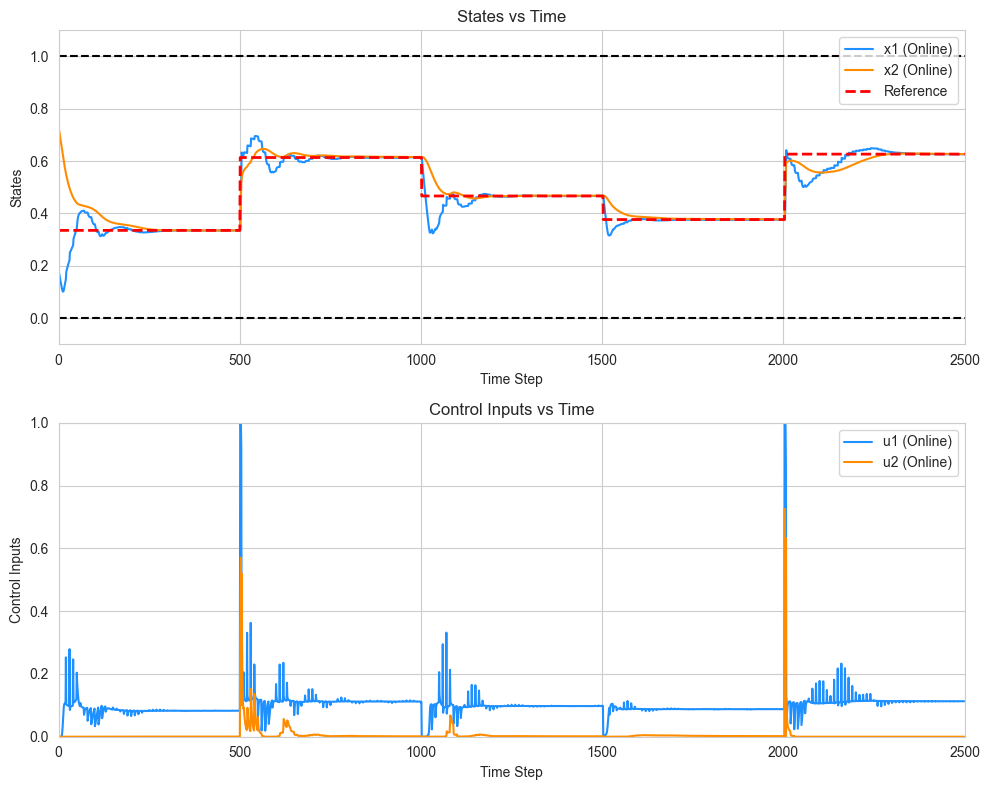

In [711]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_online_trajectory(x_trajectory, u_trajectory, reference_signal):
    """
    Plot the online system trajectory (states and controls) alongside the reference signal.

    Parameters:
    - x_trajectory: torch.Tensor of shape (1, T+1, nx)
    - u_trajectory: torch.Tensor of shape (1, T, nu)
    - reference_signal: torch.Tensor of shape (1, T+1, nx)
    """
    sns.set_style('whitegrid')

    x_np = x_trajectory.squeeze(0).cpu().numpy()  # shape: (T+1, nx)
    u_np = u_trajectory.squeeze(0).cpu().numpy()  # shape: (T, nu)
    r_np = reference_signal.squeeze(0).cpu().numpy()  # shape: (T+1, nx)

    nsteps = x_np.shape[0] - 1
    time_x = np.arange(nsteps + 1)
    time_u = np.arange(nsteps)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot x1 and x2 trajectories
    axes[0].plot(time_x, x_np[:, 0], label='x1 (Online)', color='dodgerblue')
    axes[0].plot(time_x, x_np[:, 1], label='x2 (Online)', color='darkorange')

    # Plot reference signal
    axes[0].plot(time_x, r_np[:, 0], 'r--', label='Reference', linewidth=2)

    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("States")
    axes[0].set_title("States vs Time")
    axes[0].set_xlim([0, nsteps])
    axes[0].set_ylim([-0.1, 1.1])
    axes[0].hlines([0, 1], xmin=0, xmax=nsteps, colors='black', linestyles='dashed')
    axes[0].legend()

    # Plot u1 and u2
    axes[1].plot(time_u, u_np[:, 0], label='u1 (Online)', color='dodgerblue')
    axes[1].plot(time_u, u_np[:, 1], label='u2 (Online)', color='darkorange')

    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Control Inputs")
    axes[1].set_title("Control Inputs vs Time")
    axes[1].set_xlim([0, nsteps])
    axes[1].set_ylim([0, 1])
    axes[1].legend()

    plt.tight_layout()
    plt.show()
plot_online_trajectory(x_trajectory, torch.cat(U_buffer, dim=0), data['r'][:,:len(x_trajectory[0]),:])

In [712]:
def plot_adaptation_comparison(x_before, x_after, u_before, u_after, reference_signal):
    """
    Plot system trajectories and control inputs before and after adaptation, alongside the reference signal.

    Parameters:
    - x_before: torch.Tensor of shape (1, T+1, nx)
    - x_after: torch.Tensor of shape (1, T+1, nx)
    - u_before: torch.Tensor of shape (1, T, nu)
    - u_after: torch.Tensor of shape (1, T, nu)
    - reference_signal: torch.Tensor of shape (1, T+1, nx)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    before_color='blue'
    after_color='red'
    sns.set_style('whitegrid')

    # Convert to numpy
    x_before_np = x_before.squeeze(0).cpu().numpy()
    x_after_np = x_after.squeeze(0).cpu().numpy()
    u_before_np = u_before.squeeze(0).cpu().numpy()
    u_after_np = u_after.squeeze(0).cpu().numpy()
    r_np = reference_signal.squeeze(0).cpu().numpy()

    nsteps = x_before_np.shape[0] - 1
    time_x = np.arange(nsteps + 1)
    time_u = np.arange(nsteps)

    fig, axes = plt.subplots(2, 1, figsize=(6, 8))

    # Plot states (x1 and x2)
    axes[0].plot(time_x, x_before_np[:, 0], label='x1 (Before)', color=before_color)
    axes[0].plot(time_x, x_before_np[:, 1], label='x2 (Before)', color=before_color)

    axes[0].plot(time_x, x_after_np[:, 0], label='x1 (After)', color=after_color)
    axes[0].plot(time_x, x_after_np[:, 1], label='x2 (After)', color=after_color)

    # Reference
    axes[0].plot(time_x, r_np[:, 0], color='black', linestyle="--", label='Reference x1', linewidth=1.5)

    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("States")
    axes[0].set_title("States Before and After Adaptation")
    axes[0].set_xlim([0, nsteps])
    axes[0].set_ylim([-0.1, 1.1])
    axes[0].hlines([0, 1], xmin=0, xmax=nsteps, colors='gray', linestyles='dashed')
    axes[0].legend()

    # Plot control inputs (u1 and u2)
    axes[1].plot(time_u, u_before_np[:, 0], label='u1 (Before)', color=before_color)
    axes[1].plot(time_u, u_before_np[:, 1], label='u2 (Before)', color=before_color)

    axes[1].plot(time_u, u_after_np[:, 0], label='u1 (After)', color=after_color)
    axes[1].plot(time_u, u_after_np[:, 1], label='u2 (After)', color=after_color)

    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Control Inputs")
    axes[1].set_title("Control Inputs Before and After Adaptation")
    axes[1].set_xlim([0, nsteps])
    axes[1].set_ylim([0, 1])
    axes[1].legend()

    plt.tight_layout()
    plt.show()


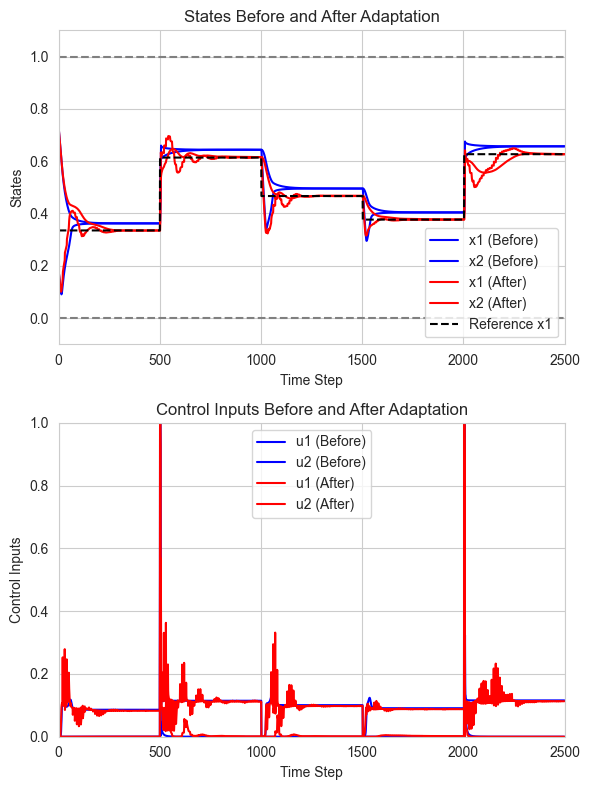

In [713]:
plot_adaptation_comparison(x_before=trajectories_before_adaptation['xn'].detach(),
                           x_after=x_trajectory,
                           u_before=trajectories_before_adaptation['u'][0].detach(),
                           u_after=torch.cat(U_buffer, dim=0),
                           reference_signal=data['r'][:,:len(x_trajectory[0]),:])

### Full rollout after adaptation on new data

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

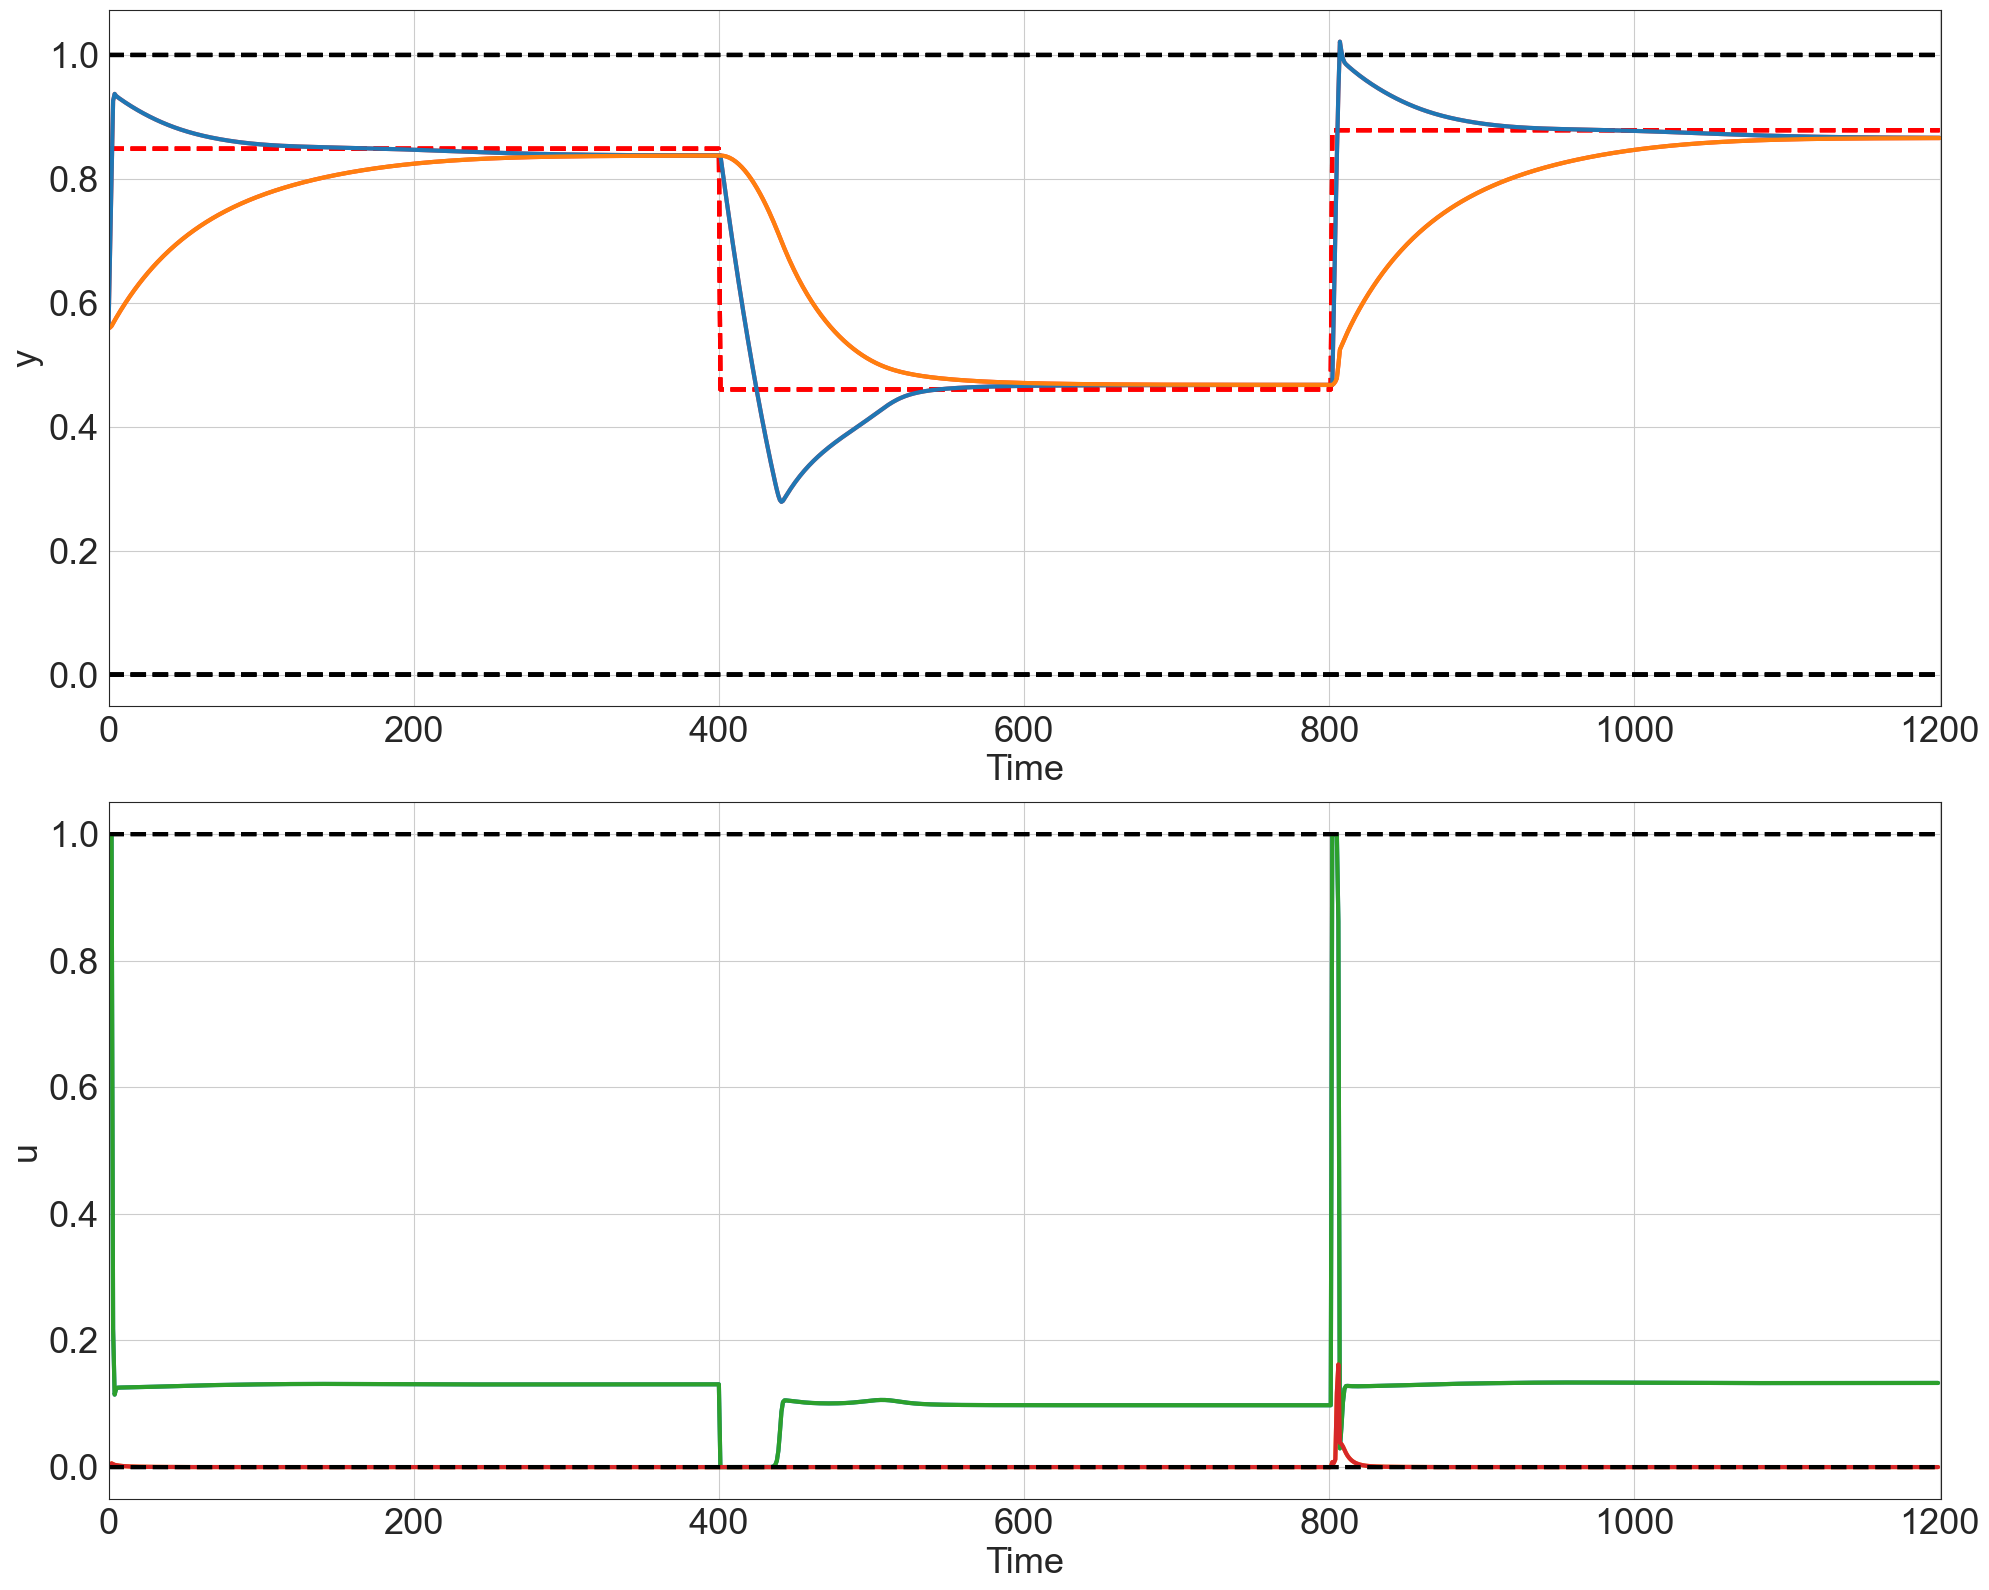

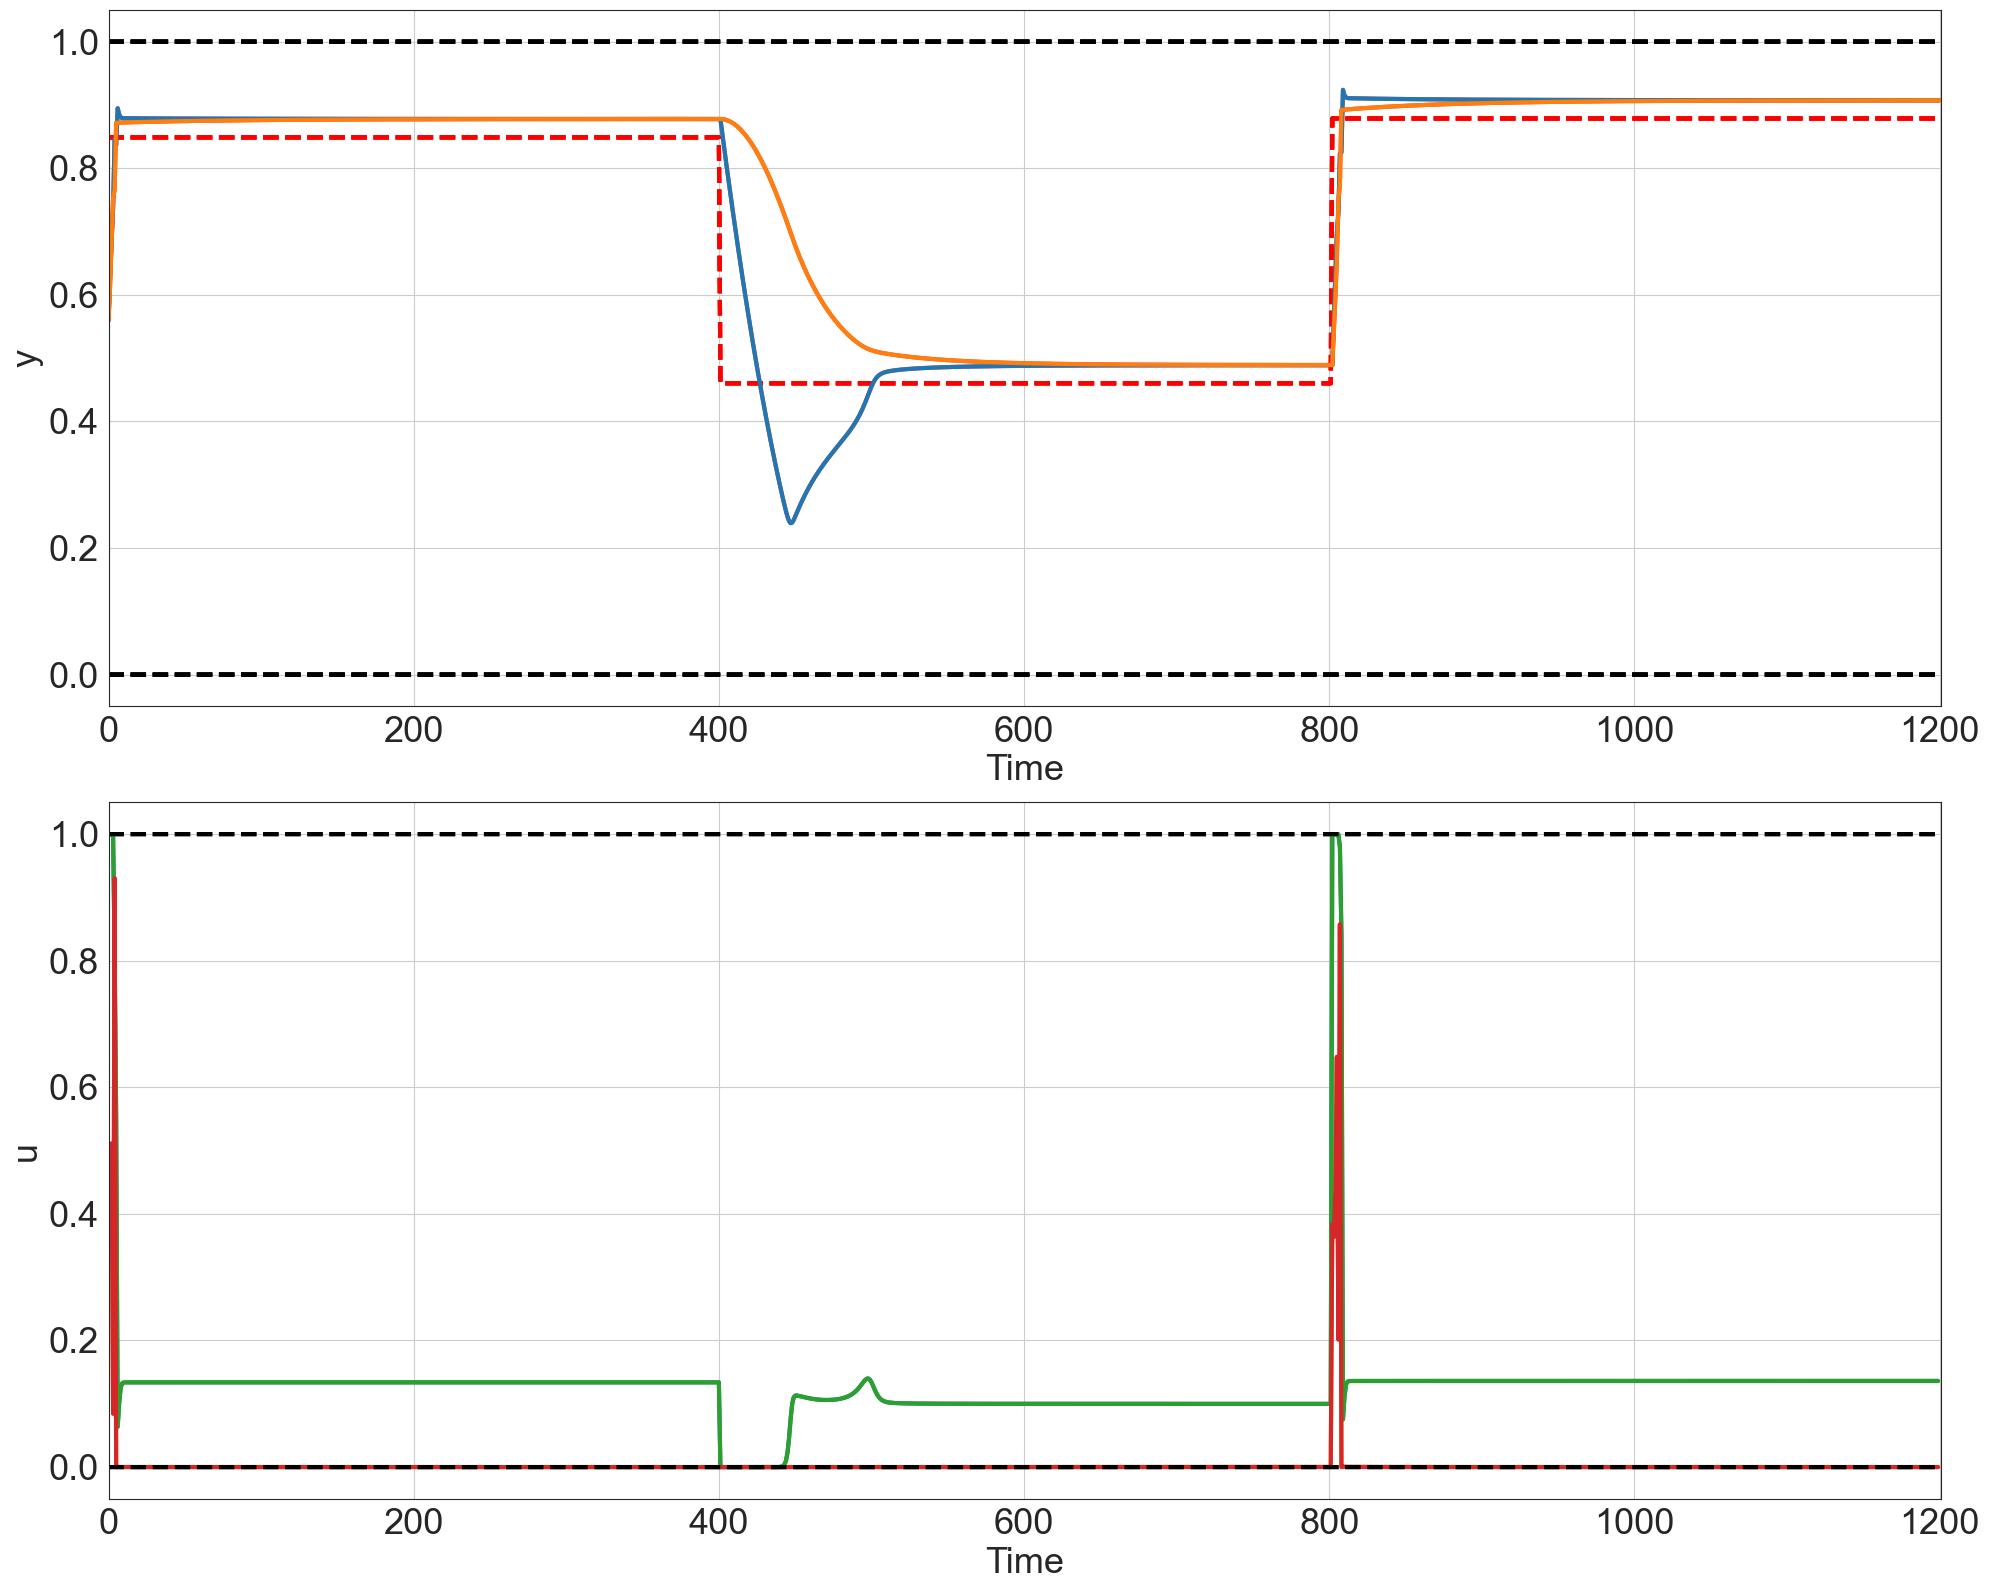

In [720]:
import numpy as np
import seaborn as sns
from neuromancer.plot import pltCL, pltPhase

sns.set_style('white')
nsteps = 1200
step_length = 400
seed = 4
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=0., max=0.9, randsteps=nsteps//step_length, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

gt_NN_policy_wb_after = System([nominal_policy_model,sys_node])
gt_NN_policy_wb_after.nsteps = nsteps
# perform closed-loop simulation
trajectories_after_adaptation = gt_NN_policy_wb_after(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories_after_adaptation['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories_after_adaptation['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories_after_adaptation['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax, )


gt_NN_policy_wb = System([policy,sys_node])
gt_NN_policy_wb.nsteps = nsteps
# perform closed-loop simulation
trajectories_after_adaptation = gt_NN_policy_wb(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories_after_adaptation['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories_after_adaptation['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories_after_adaptation['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)
